In [1]:
%run func_def.ipynb

imports loaded.

> Pre-Processing func:
    get_height(item)
    get_weight(item)
    get_reach(item)
    get_std_reach(item, height, reach_list, height_list)
    get_age(item)
    get_std_age(item, age_list)
    get_win_prob(name, date, df)
    get_win_streak(name, date, df) #return count of recent wins
    get_lose_streak(name, date, df)
    get_fighter_stats(name, data )

> Feature Engineering func:
    get_stat(index, data, stat='height', fo='')
    get_swaped_row(index, data) # return fighter & opponent statistics swapped. 
    get_wins(combo, data)
    get_wins_ratio(combo, data)

> outlier_cleaning func:
    set_outlier_detection_model(X_columns, data)

> model_stats_pred_training func:
    set_lower_cases(string)
    set_train_test(X_columns, y_columns, data, test_size=0.3, valid_size=0.3)
    set_xgboost_reg(X_columns, y_columns, data, n=200, learning_rate=0.2, subsample=0.4, max_depth=5)
    set_predictions(model, data, X_columns, y_columns)
    get_mean_percentage_error(act,

### <span style='color:green'> **[done]** </span>Loading stats & results trained data:

In [2]:
df = pd.read_csv('../data/data_features_outliers_detected.csv')
df.tail(3)

,result,fighter,opponent,date,weight_class,method,type,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,outlier,lof_outlier
6314,lose,Alberta Cerra Leon,Remco Pardoel,1994-03-11,Open Weight,SUB,Ezekiel Choke,0.00533,-0.126910,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,-1.724902,-0.02043,-0.001147,-0.018238,False,False
6315,win,Orlando Wiet,Robert Lucarelli,1994-03-11,Open Weight,KO/TKO,Other,0.00533,0.204580,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,1.090338,-0.02043,-0.001147,-0.018238,False,False
6316,win,Johnny Rhodes,David Levicki,1994-03-11,Open Weight,KO/TKO,Punches,0.00533,0.241412,0.405662,-0.003396,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,0.198831,-0.02043,-0.001147,-0.018238,False,False


### <span style='color:green'> **[done]** </span>Define X & Y:

In [3]:
req_data = ['date','weight_class','fighter','opponent']
y = ['method']
X = ['result','kd_dif','str_dif','td_dif','sub_dif',
    'td_avg_dif','td_def_dif','sub_avg_dif',
    'slpm_dif','str_acc_dif','sapm_dif','str_def_dif',
    'stance_win_ratio','win_perc_dif','win_strk_dif','lose_strk_dif'
    ]

df = df[req_data + X + y]
df.tail(3)

,date,weight_class,fighter,opponent,result,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,method
6314,1994-03-11,Open Weight,Alberta Cerra Leon,Remco Pardoel,lose,0.00533,-0.126910,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,-1.724902,-0.02043,-0.001147,-0.018238,SUB
6315,1994-03-11,Open Weight,Orlando Wiet,Robert Lucarelli,win,0.00533,0.204580,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,1.090338,-0.02043,-0.001147,-0.018238,KO/TKO
6316,1994-03-11,Open Weight,Johnny Rhodes,David Levicki,win,0.00533,0.241412,0.405662,-0.003396,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,0.198831,-0.02043,-0.001147,-0.018238,KO/TKO


### <span style='color:green'> **[done]** </span>Feature relevant methods only

In [4]:
for i in tqdm(range(0,len(df))):
    
    method = str(df.loc[i,'method'])
    
    if method.find('KO/TKO') != -1:
        df.loc[i,'method'] = 'knockout'
    elif method.find('DEC') != -1:
        df.loc[i,'method'] = 'decision'
    elif method.find('SUB') != -1:
        df.loc[i,'method'] = 'submission'
    elif method.find('DQ') != -1:
        df.loc[i,'method'] = 'disqual'

df = df[df.method != 'disqual'].reset_index(drop=True)         
df.method.unique() 

100%|███████████████████████████████████████████████████████████████████████████| 6317/6317 [00:00<00:00, 17124.69it/s]


array(['decision', 'knockout', 'submission'], dtype=object)

### <span style='color:green'> **[done]** </span>Transform Categorical feature "result" to fit classifier model:

In [5]:
for i in tqdm(range(len(df))):
    fighter = df.loc[i,'fighter']
    result = df.loc[i,'result']
    df.loc[i,'result'] = len(df[(df.result==result)&(df.fighter==fighter)])/len(df[df.fighter==fighter])

df.tail(3)

100%|█████████████████████████████████████████████████████████████████████████████| 6299/6299 [00:18<00:00, 336.59it/s]


,date,weight_class,fighter,opponent,result,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,method
6296,1994-03-11,Open Weight,Alberta Cerra Leon,Remco Pardoel,1.0,0.00533,-0.126910,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,-1.724902,-0.02043,-0.001147,-0.018238,submission
6297,1994-03-11,Open Weight,Orlando Wiet,Robert Lucarelli,1.0,0.00533,0.204580,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,1.090338,-0.02043,-0.001147,-0.018238,knockout
6298,1994-03-11,Open Weight,Johnny Rhodes,David Levicki,0.5,0.00533,0.241412,0.405662,-0.003396,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,0.198831,-0.02043,-0.001147,-0.018238,knockout


### <span style='color:green'> **[done]** </span>Set KNN model:

In [6]:
df = set_train_test(X_columns=X, y_columns=y, data=df, test_size=0.3, valid_size=0.3)
df.tail(3)

Data split: Data=(6299, 22), train_set=(3071, 16), validation_set=(1342, 16), test_set=(1886, 16)


,set,date,weight_class,fighter,opponent,result,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,method
6296,validation,1994-03-11,Open Weight,Alberta Cerra Leon,Remco Pardoel,1.0,0.00533,-0.126910,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,-1.724902,-0.02043,-0.001147,-0.018238,submission
6297,test,1994-03-11,Open Weight,Orlando Wiet,Robert Lucarelli,1.0,0.00533,0.204580,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,1.090338,-0.02043,-0.001147,-0.018238,knockout
6298,train,1994-03-11,Open Weight,Johnny Rhodes,David Levicki,0.5,0.00533,0.241412,0.405662,-0.003396,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,0.198831,-0.02043,-0.001147,-0.018238,knockout


In [7]:
knn = set_knn_clf(X_columns=X, y_columns=y, data=df, neighbors=5)
df['method_pred'] = knn.predict(df[X])
df.tail(3)

,set,date,weight_class,fighter,opponent,result,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,method,method_pred
6296,validation,1994-03-11,Open Weight,Alberta Cerra Leon,Remco Pardoel,1.0,0.00533,-0.126910,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,-1.724902,-0.02043,-0.001147,-0.018238,submission,submission
6297,test,1994-03-11,Open Weight,Orlando Wiet,Robert Lucarelli,1.0,0.00533,0.204580,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,1.090338,-0.02043,-0.001147,-0.018238,knockout,submission
6298,train,1994-03-11,Open Weight,Johnny Rhodes,David Levicki,0.5,0.00533,0.241412,0.405662,-0.003396,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,0.198831,-0.02043,-0.001147,-0.018238,knockout,knockout


Initial Model Score:
Accuracy = 0.596501


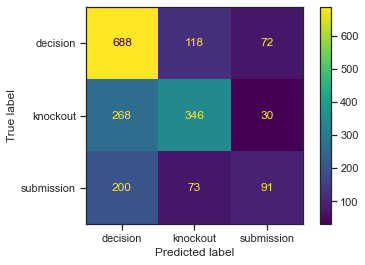

In [8]:
print('Initial Model Score:')
get_model_evaluation(data=df,y_column='method')

### <span style='color:green'> **[done]** </span>Gridsearch - Parameter Tuning:

In [9]:
train_index = df.index[df.set=='train']
valid_index = df.index[df.set=='validation']

grid = {'n_neighbors':[],
       'train_accuracy':[],
       'valid_accuracy':[],
       }

for n in tqdm([1,3,5,10,15,30,50,100]):
    grid['n_neighbors'].append(n)
    knn = set_knn_clf(X_columns=X, y_columns=y, data=df, neighbors=n)
    df = set_predictions(data=df,model=knn, X_columns=X, y_columns=y)
    grid['train_accuracy'].append(get_mean_accuracy(act=df.loc[train_index,'method'], pred=df.loc[train_index,'method_pred']))
    grid['valid_accuracy'].append(get_mean_accuracy(act=df.loc[valid_index,'method'], pred=df.loc[valid_index,'method_pred']))
    
grid = grid = pd.DataFrame(data=grid)
grid

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s]


,n_neighbors,train_accuracy,valid_accuracy
0,1,1.000000,0.567064
1,3,0.760013,0.587928
2,5,0.706285,0.623696
3,10,0.685444,0.627422
4,15,0.666558,0.608793
5,30,0.647021,0.608048
6,50,0.631390,0.609538
7,100,0.598502,0.583458


Text(0, 0.5, 'Accuracy')

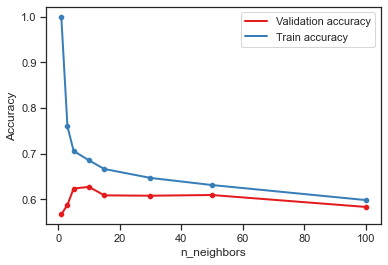

In [10]:
sns.lineplot( data=grid, x='n_neighbors', y='valid_accuracy', label='Validation accuracy')
sns.scatterplot( data=grid, x='n_neighbors', y='valid_accuracy')
sns.lineplot( data=grid, x='n_neighbors', y='train_accuracy', label='Train accuracy')
sns.scatterplot( data=grid, x='n_neighbors', y='train_accuracy')
plt.ylabel("Accuracy")

In [11]:
best_model_param = grid.sort_values(by=['valid_accuracy','n_neighbors'], ascending=False).reset_index(drop=True)
best_c = best_model_param.iloc[0]['n_neighbors']
best_model_param.iloc[0]

n_neighbors       10.000000
train_accuracy     0.685444
valid_accuracy     0.627422
Name: 0, dtype: float64

#### <span style='color:green'> **[done]** </span> Add predictions to data:

In [12]:
pred_columns = ['method_pred']
pred = df[['date','fighter','opponent'] + pred_columns]
pred.tail(3)

,date,fighter,opponent,method_pred
6296,1994-03-11,Alberta Cerra Leon,Remco Pardoel,decision
6297,1994-03-11,Orlando Wiet,Robert Lucarelli,decision
6298,1994-03-11,Johnny Rhodes,David Levicki,decision


In [13]:
data = pd.read_csv('../data/data_features_outliers_detected.csv')
data = pd.merge(data,pred, on=['date','fighter','opponent'], how='outer')

data.to_csv('../data/data_method_prediction_set.csv', index=None)
print('../data/data_method_prediction_set.csv saved.')
print('method_pred: %s' %data.method_pred.unique())
data.tail(3)

../data/data_method_prediction_set.csv saved.
method_pred: ['decision' 'knockout' 'submission' nan]


,result,fighter,opponent,date,weight_class,method,type,kd_dif,str_dif,td_dif,sub_dif,td_avg_dif,td_def_dif,sub_avg_dif,slpm_dif,str_acc_dif,sapm_dif,str_def_dif,stance_win_ratio,win_perc_dif,win_strk_dif,lose_strk_dif,outlier,lof_outlier,method_pred
6314,lose,Alberta Cerra Leon,Remco Pardoel,1994-03-11,Open Weight,SUB,Ezekiel Choke,0.00533,-0.126910,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,-1.724902,-0.02043,-0.001147,-0.018238,False,False,decision
6315,win,Orlando Wiet,Robert Lucarelli,1994-03-11,Open Weight,KO/TKO,Other,0.00533,0.204580,-0.379439,-0.861399,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,1.090338,-0.02043,-0.001147,-0.018238,False,False,decision
6316,win,Johnny Rhodes,David Levicki,1994-03-11,Open Weight,KO/TKO,Punches,0.00533,0.241412,0.405662,-0.003396,0.009735,-0.018019,0.0,-0.037055,-0.029317,-0.000684,-0.009917,0.198831,-0.02043,-0.001147,-0.018238,False,False,decision


#### <span style='color:green'> **[done]** </span> Saving model as pickle:

In [14]:
save_trained_model(model=knn,filename_path='../global_variables/method_pred_knn_classifier.pkl')

../global_variables/method_pred_knn_classifier.pkl saved.


#### <span style='color:green'> **[done]** </span> saving data:

In [15]:
try:
    df.to_csv('../data/data_result_prediction_set.csv',index=None)
    print('../data/data_result_prediction_set.csv saved.')
except:
    print('error occurs saving ../data/data_result_prediction_set.csv - might be file in use.')

../data/data_result_prediction_set.csv saved.
